# Imports

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import bayesflow as bf

import seaborn as sns
import time

print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

# Data generating process

## Definitions

In [ ]:
def generate_logPK(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None):
    """
    Generate noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-3 to ~3.16
        noise_level (float): relative Gaussian noise (e.g., 0.05 = 5%)

    Returns:
        noisy_P_k (np.array): noisy matter power spectrum at redshift z=0
    """
    # Default k range: safe values for CAMB
    if k_vals is None:
        k_vals = np.logspace(-4, 1, 1024)


    ## To calculate the physical densities from the densities 
    # Baryon density
    Omega_b = 0.05
    
    # Cold dark matter density
    Omega_c = Omega_m - Omega_b

    # dimensionless Hubble parameter
    h = H0 / 100

    
    # physical densities
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2


    # Setup CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    # Run CAMB and get P(k)
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

     # Conditional RNG
    if seed is not None:
        rng = np.random.default_rng(seed)  # reproducible
    else:
        rng = np.random.default_rng()      # fresh random

    # Add heteroscedastic Gaussian noise.
    # Noise is added according to the scale of P_k which make more realistic observations
    # noise = rng.normal(0, noise_level * P_k)
    # P_k_noisy = P_k + noise

    # Step 2: Apply log10 to each output
    log_k = np.log10(k_vals)
    #log_P_k_noisy = np.log10(P_k_noisy)
    
    
    
    
    log_P_k_clean = np.log10(P_k)

    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise
    
    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {     
        'log_k': log_k,
        'log_P_k_noisy': log_P_k_noisy,
        'log_P_k_clean': log_P_k_clean  
    }

## Generating noisy observations

$\theta^*$, True parameter from Planck 2018

In [ ]:
# Define the true cosmological parameters
theta_star = {
    'H0': 67.4,
    'Omega_m': 0.315,
    'n_s': 0.965
}

In [211]:
# Generate the noisy power spectrum using theta_star
Log_Pk_obs = generate_logPK(
    H0=theta_star['H0'],
    Omega_m=theta_star['Omega_m'],
    n_s=theta_star['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    seed=42            # Optional, for reproducibility
)

## Visualization

P(k) vs k_vals

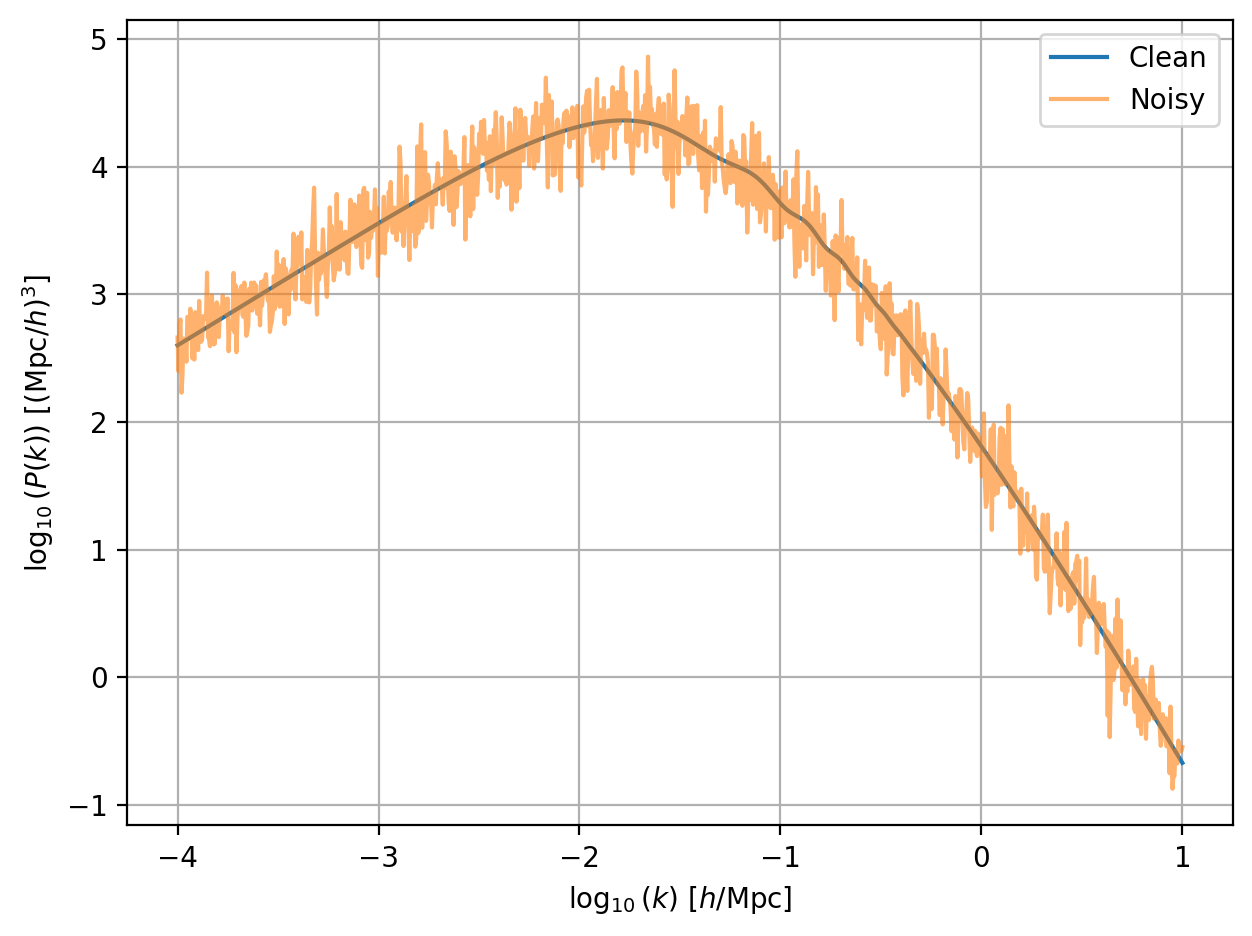

In [212]:
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_clean'], label='Clean')
plt.plot(Log_Pk_obs['log_k'], Log_Pk_obs['log_P_k_noisy'], label='Noisy', alpha=0.6)
plt.xlabel(r'$\log_{10}(k)\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\log_{10}(P(k))\ [(\mathrm{Mpc}/h)^3]$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

$f(P\_k))$, probability density of power spectrum

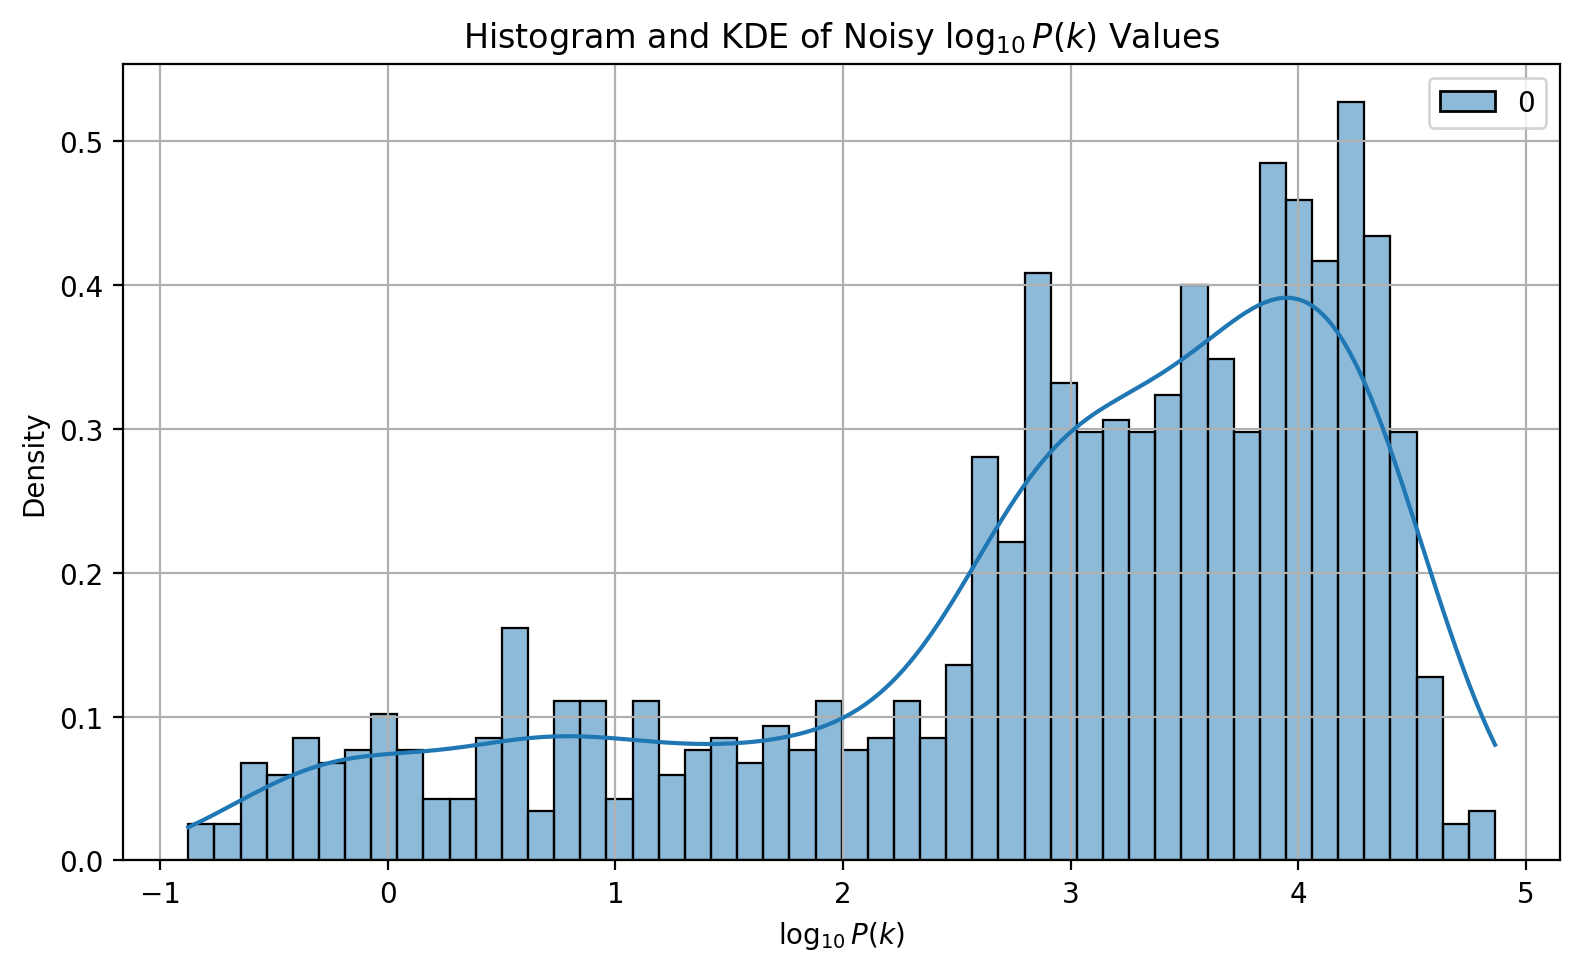

In [213]:

# Plot histogram and KDE
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_obs['log_P_k_noisy'], bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


## Definitions part 2

Sample from prior: $(\theta^{(s)}) \sim P(\theta)$

In [1]:
def prior(seed=None):
    rng = np.random.default_rng(seed)

    H0 = rng.uniform(40, 100)
    Omega_m = rng.uniform(0.1, 0.6)
    n_s = rng.uniform(0.8, 1.5)

    return {
        'H0': H0,
        'Omega_m': Omega_m,
        'n_s': n_s
    }


Sample from the Likelihood: $(y^{(s)}) \sim P(y | \theta)$
The same function but with just one output of length of k_vals

In [2]:
def likelihood(H0, Omega_m, n_s, k_vals=None, noise_level=0.2, seed=None, n = 256):
    """
    Generate log10 of the noisy matter power spectrum P(k) from given cosmological parameters.

    Parameters:
        H0 (float): Hubble constant (km/s/Mpc)
        Omega_m (float): total matter density (Ω_m)
        n_s (float): spectral index
        k_vals (np.array or None): k values (1/Mpc). Default: logspace from 1e-4 to 10
        noise_level (float): standard deviation of additive Gaussian noise in log space
        seed (int or None): for reproducibility

    Returns:
        log_P_k_noisy (np.array): noisy log10 power spectrum at z = 0
    """

    if k_vals is None:
        k_vals = np.logspace(-4, 1, n)

    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    h = H0 / 100
    ombh2 = Omega_b * h**2
    omch2 = Omega_c * h**2

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0], kmax=max(k_vals))

    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, kmax=max(k_vals))
    P_k = PK.P(0, k_vals)

    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    log_k = np.log10(k_vals)
    log_P_k_clean = np.log10(P_k)
    log_noise = rng.normal(0, noise_level, len(P_k))
    log_P_k_noisy = log_P_k_clean + log_noise


    # shape adjustments
    log_k = log_k.reshape(-1, 1)
    log_P_k_clean = log_P_k_clean.reshape(-1, 1)
    log_P_k_noisy = log_P_k_noisy.reshape(-1, 1)

    return {
        'log_P_k_noisy': log_P_k_noisy
    }

### Testing Prior and Likelihood

In [3]:
theta_test = prior()
print(theta_test)

NameError: name 'np' is not defined

In [ ]:
# Generate the noisy power spectrum using theta_star
Log_Pk_test = likelihood(
    H0=theta_test['H0'],
    Omega_m=theta_test['Omega_m'],
    n_s=theta_test['n_s'],
    noise_level=0.2,   # 20% relative Gaussian noise
    n = 512
)

In [ ]:
Log_Pk_test.keys()

In [265]:
Log_Pk_test['log_P_k_noisy'].shape

(512, 1)

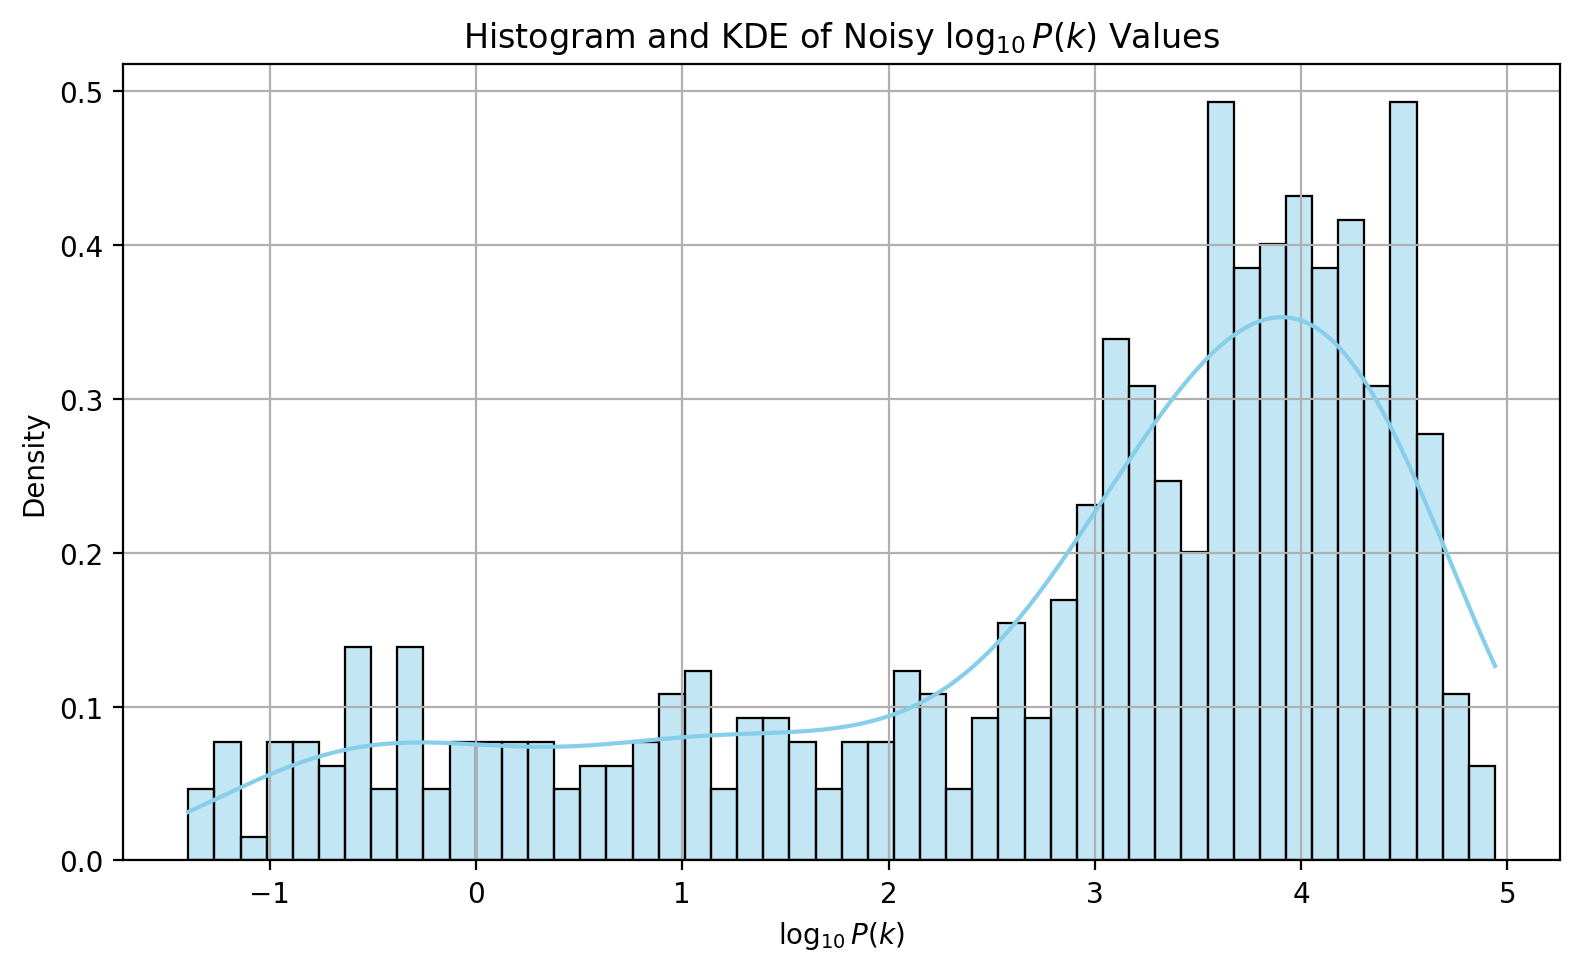

In [266]:
# Plot histogram and KDE for log10(P(k))
plt.figure(figsize=(8, 5))
sns.histplot(Log_Pk_test['log_P_k_noisy'].flatten(), bins=50, kde=True, stat="density", color='skyblue', edgecolor='black')

plt.title('Histogram and KDE of Noisy $\log_{10} P(k)$ Values')
plt.xlabel(r'$\log_{10} P(k)$')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


# Bayes Flow Workflow

## Sample from the Joint Distribution $(\theta^{(s)}, y^{(s)}) \sim P(\theta, y)$

### Simulator

In [267]:
simulator = bf.make_simulator([prior, likelihood])

In [268]:
# simulator.sample(2)

{'H0': array([[59.00127902],
        [81.35556626]]),
 'Omega_m': array([[0.38664643],
        [0.36435724]]),
 'n_s': array([[0.90253465],
        [0.92862062]]),
 'log_P_k_noisy': array([[[ 2.47342447e+00],
         [ 2.42992844e+00],
         [ 2.64064178e+00],
         [ 2.78782991e+00],
         [ 2.99904215e+00],
         [ 2.78546918e+00],
         [ 2.81106235e+00],
         [ 2.39705162e+00],
         [ 2.72970576e+00],
         [ 2.92678209e+00],
         [ 3.28143337e+00],
         [ 3.15815597e+00],
         [ 2.80954980e+00],
         [ 2.89138332e+00],
         [ 2.71989502e+00],
         [ 2.85523089e+00],
         [ 2.91164970e+00],
         [ 3.18959386e+00],
         [ 2.90403356e+00],
         [ 2.93499613e+00],
         [ 3.09788942e+00],
         [ 2.81131454e+00],
         [ 2.46877113e+00],
         [ 3.30658419e+00],
         [ 2.87811231e+00],
         [ 2.92899497e+00],
         [ 2.96791361e+00],
         [ 3.15819488e+00],
         [ 2.88153191e+00],
       

###  Adapter 

In [271]:
adapter = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
)

In [272]:
adapter_std = (
    bf.Adapter()
    .concatenate(["H0", "Omega_m", "n_s"], into="inference_variables")
    .rename("log_P_k_noisy", "summary_variables")
    .standardize("summary_variables")
)

### Summary Network

In [273]:
summary_network = bf.networks.DeepSet()

# 1) Affine Coupling Model

### Affine Inference Network

In [274]:
inference_network_affine = bf.networks.CouplingFlow() 

### Affine Workflow

In [275]:
workflow_affine = bf.BasicWorkflow(
     inference_network=inference_network_affine,
     summary_network=summary_network,
     adapter=adapter_std,
     simulator=simulator
)

### Simulating Datasets for 
1) Training
2) Validation
3) Test

In [ ]:
# Timing training data sampling
start_time = time.time()
training_data = workflow_affine.simulate(10000)
training_duration = time.time() - start_time
print(f"Training data simulation took {training_duration:.2f} seconds.")

In [ ]:
# Timing validation data sampling
start_time = time.time()
validation_data = workflow_affine.simulate(1000)
validation_duration = time.time() - start_time
print(f"Validation data simulation took {validation_duration:.2f} seconds.")

In [ ]:
# Timing test data sampling
start_time = time.time()
test_data = workflow_affine.simulate(300)
test_duration = time.time() - start_time
print(f"Test data simulation took {test_duration:.2f} seconds.")

## Just testing 

Plotting any random simulated dataset just to know whether the simulator working properly

In [316]:
training_data['log_P_k_noisy'].shape

(100, 512, 1)

In [ ]:
training_data['log_P_k_noisy'][random_idx].squeeze()

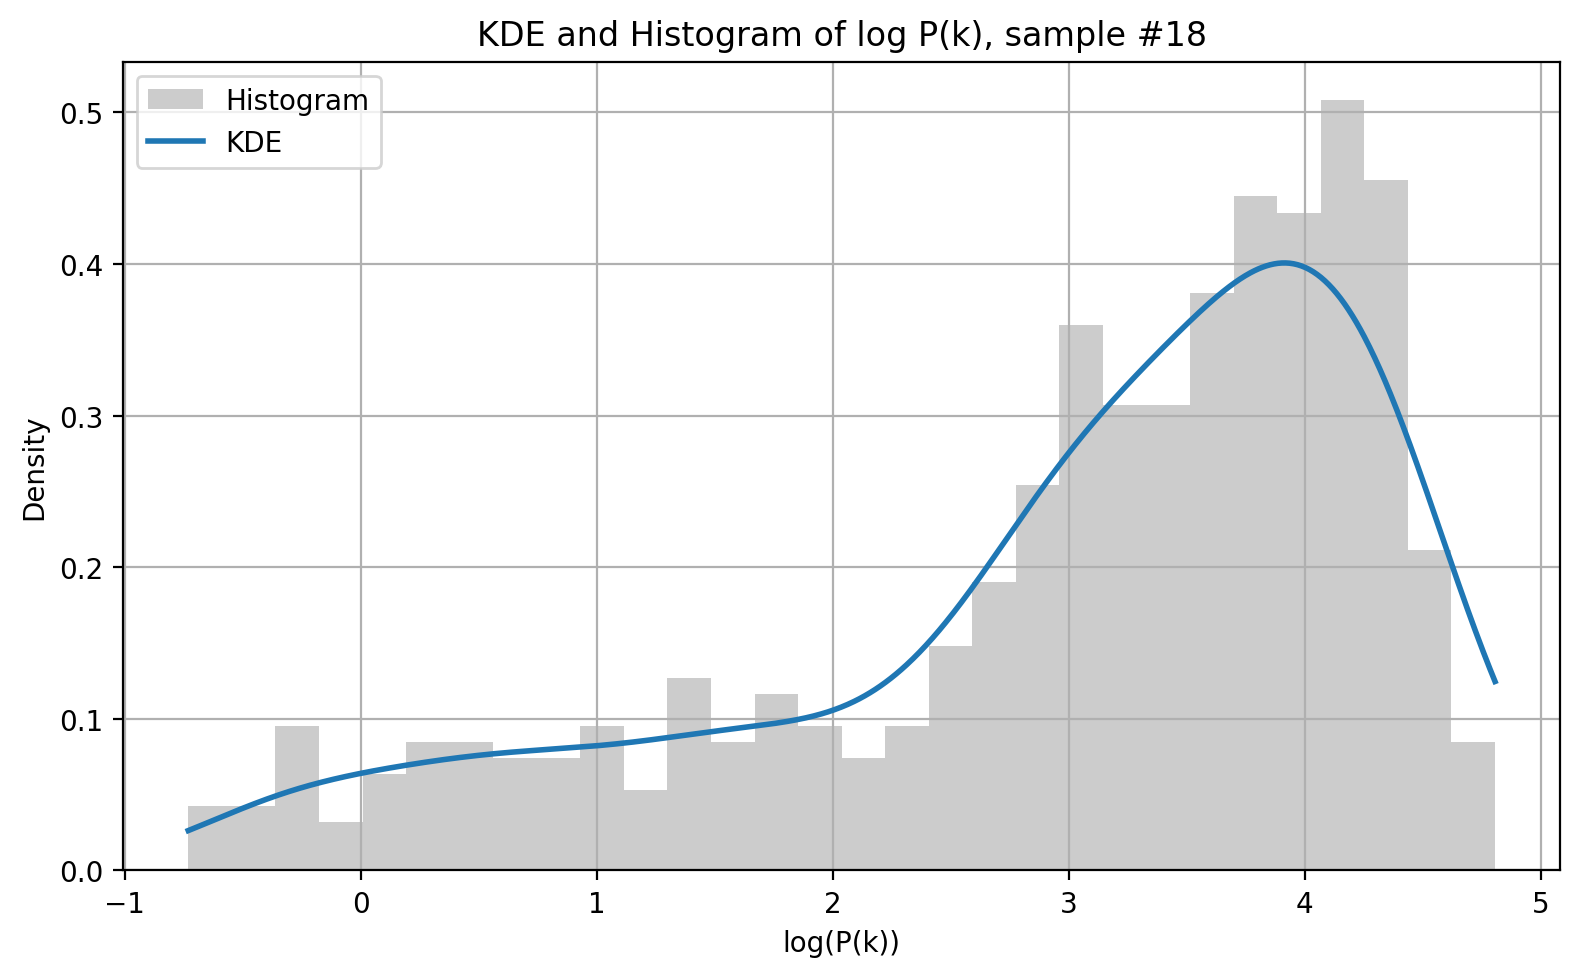

In [314]:
# Select a random sample
random_idx = np.random.randint(0, 100)

# Extract and unroll to 1D array
log_pk_sample = training_data['log_P_k_noisy'][random_idx].squeeze()

# KDE estimation
kde = gaussian_kde(log_pk_sample)
x_vals = np.linspace(log_pk_sample.min(), log_pk_sample.max(), 1000)
density = kde(x_vals)

# Plot KDE and Histogram
plt.figure(figsize=(8, 5))
plt.hist(log_pk_sample, bins=30, density=True, alpha=0.4, color='gray', label='Histogram')
plt.plot(x_vals, density, label='KDE', linewidth=2)

# Labels and titles
plt.xlabel('log(P(k))')
plt.ylabel('Density')
plt.title(f'KDE and Histogram of log P(k), sample #{random_idx}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


This means that the simulator is correct

# Training affine 

In [257]:
history_affine = workflow_affine.fit_offline(
    data = test_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = test_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - loss: 4.3291 - val_loss: 4.1863
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 4.4044 - val_loss: 4.0470
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 4.0676 - val_loss: 3.9999
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 4.0399 - val_loss: 3.8892
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 3.9668 - val_loss: 3.6970
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 3.8036 - val_loss: 3.7134
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 3.7206 - val_loss: 3.5638
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 3.5927 - val_loss: 3.4531
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 3.5297 - val_loss: 3.4246
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 3.4085 - val_loss: 3.3412
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 3.3519 - val_loss: 3.1384
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 3.08

In [245]:
print(training_data["log_P_k_noisy"].shape)
print(training_data["H0"].shape)
print(training_data["Omega_m"].shape)
print(training_data["n_s"].shape)

(100, 512, 1)
(100, 1)
(100, 1)
(100, 1)


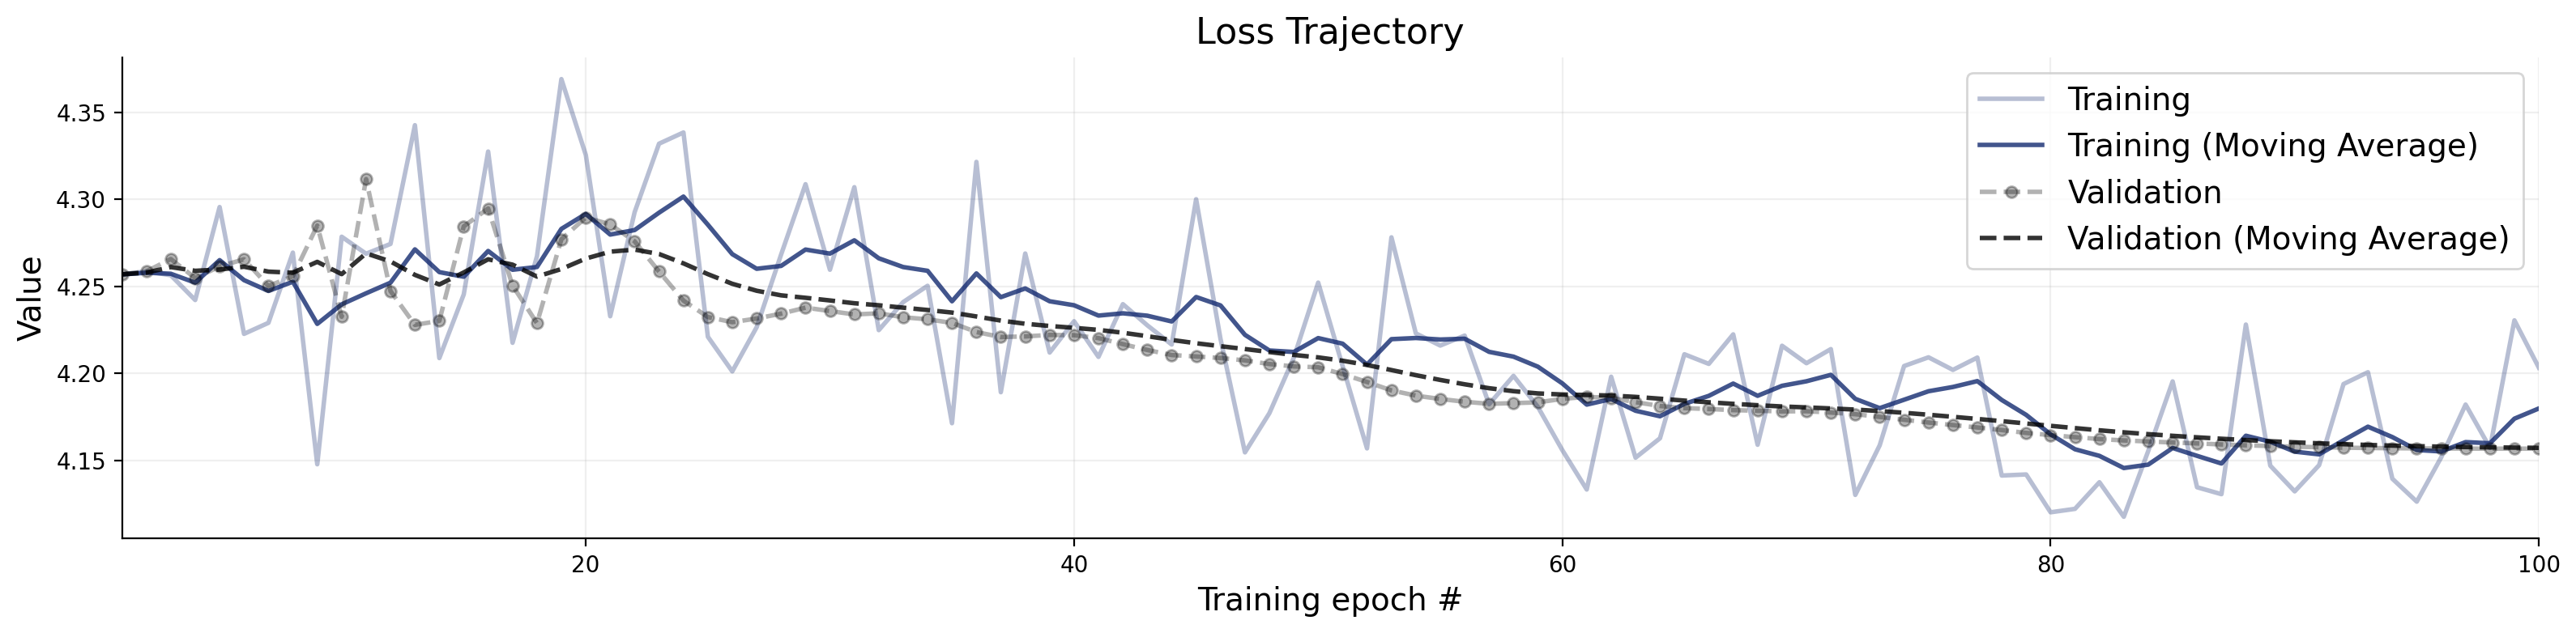

In [246]:
f_affine = bf.diagnostics.plots.loss(history_affine)

# Test Data

### Sample posterior from the trained affine inference network
Sample 1000 posterior samples from each simulated dataset of 300

In [258]:
post_samples_affine = workflow_affine.sample(conditions=test_data, num_samples=1000)

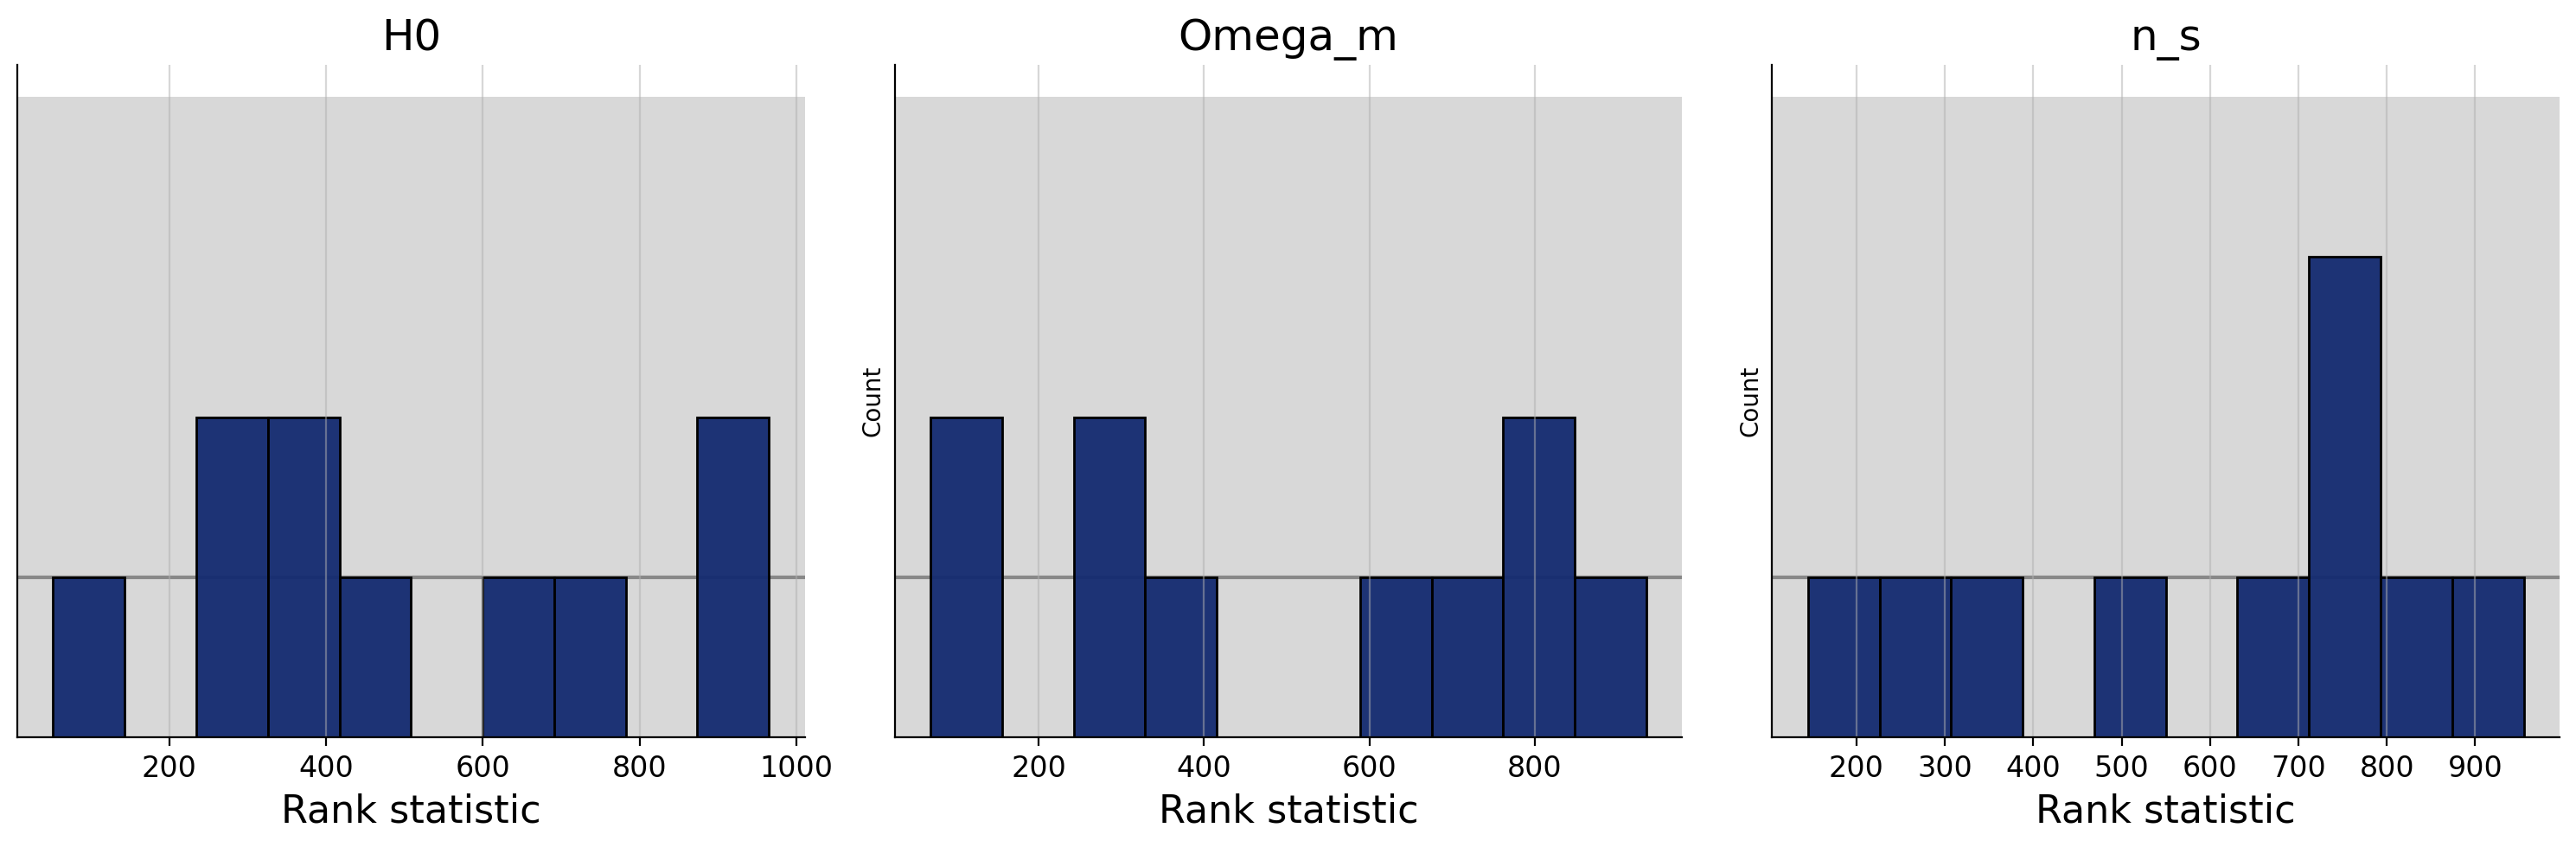

In [259]:
rank_affine = bf.diagnostics.plots.calibration_histogram(post_samples_affine, test_data)

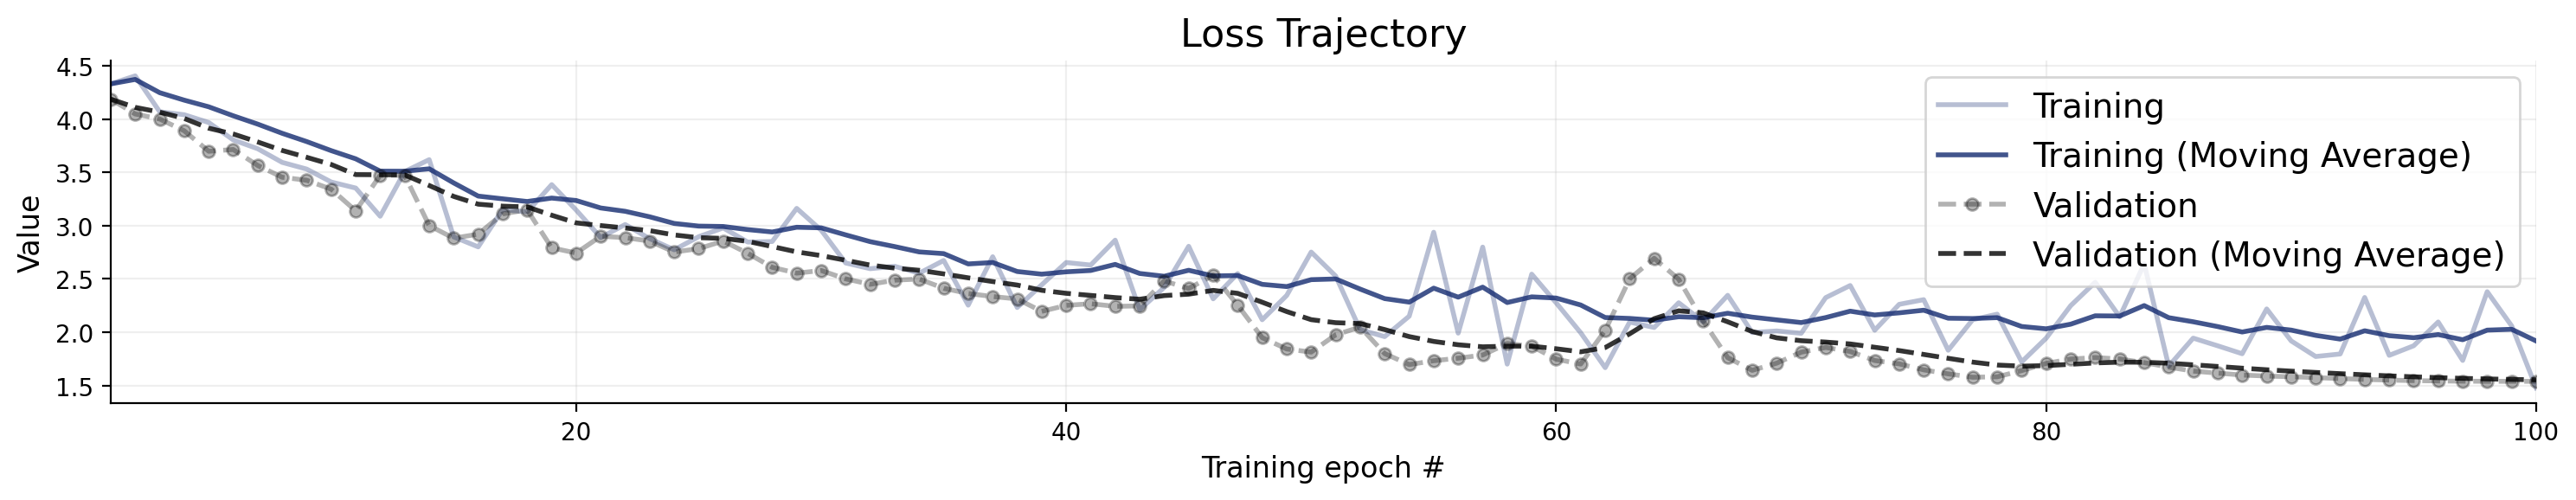

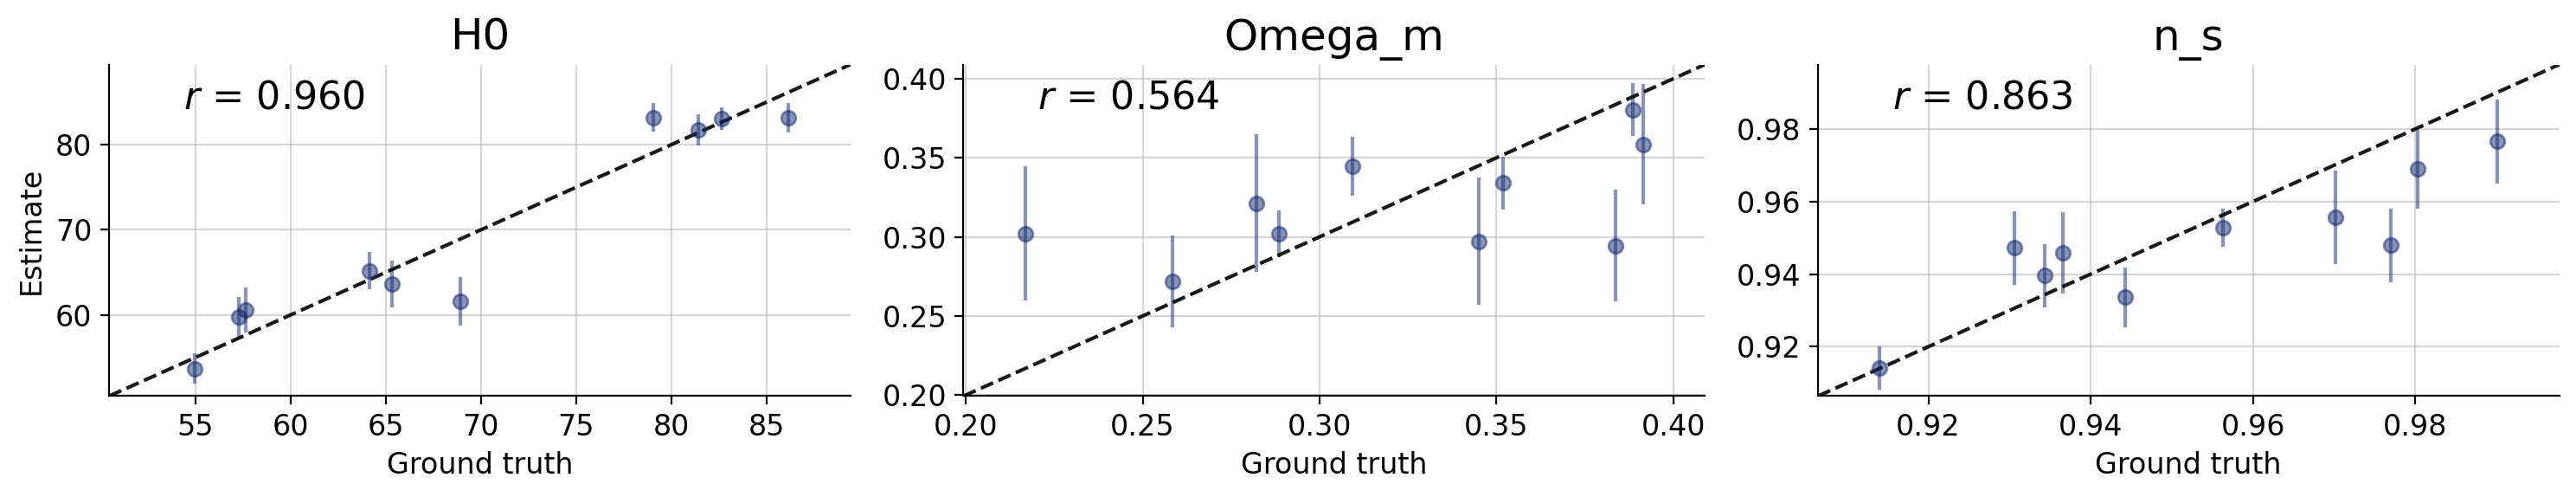

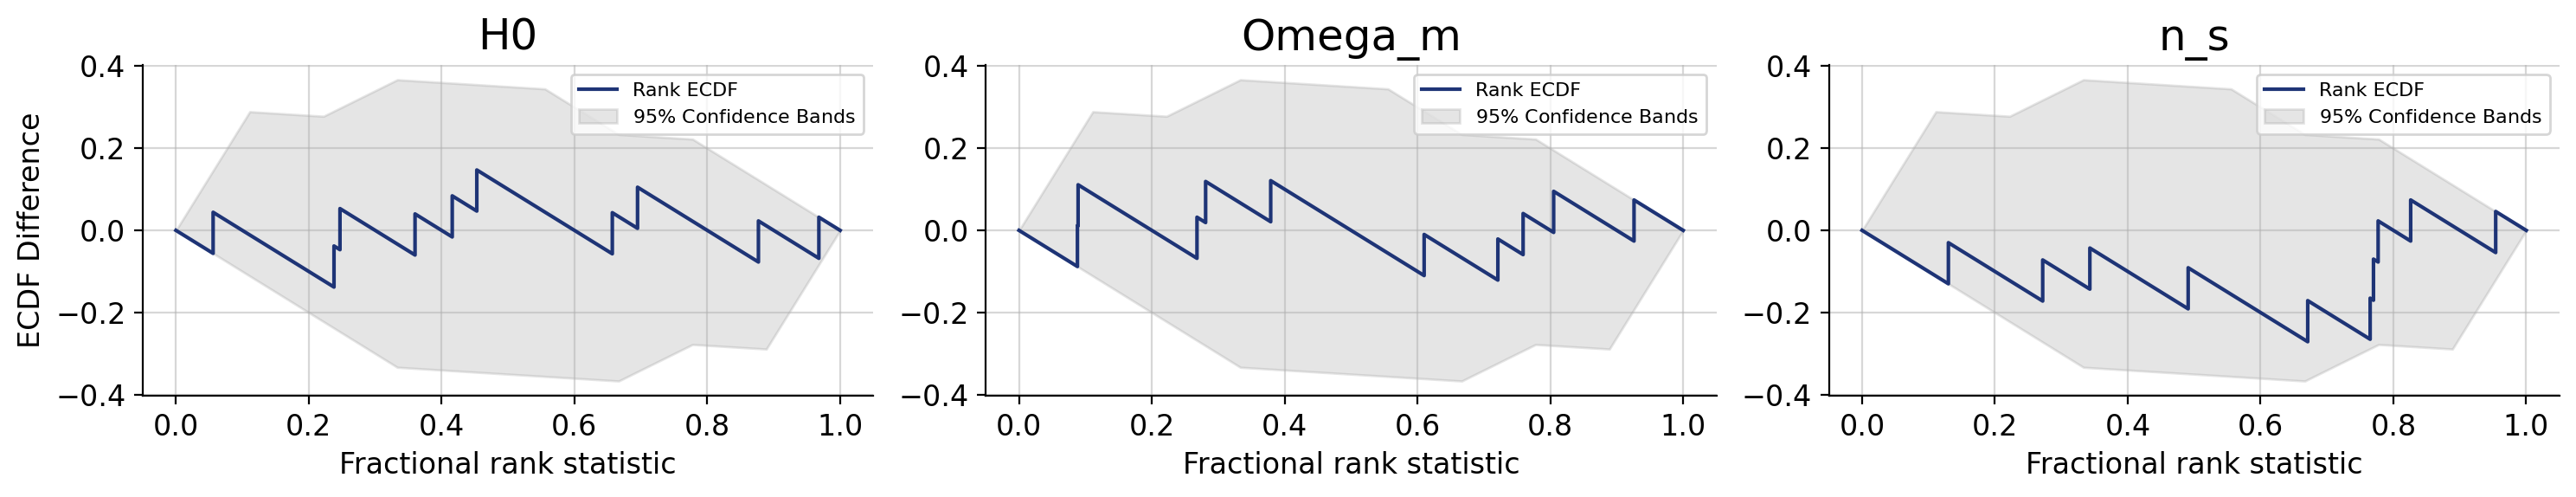

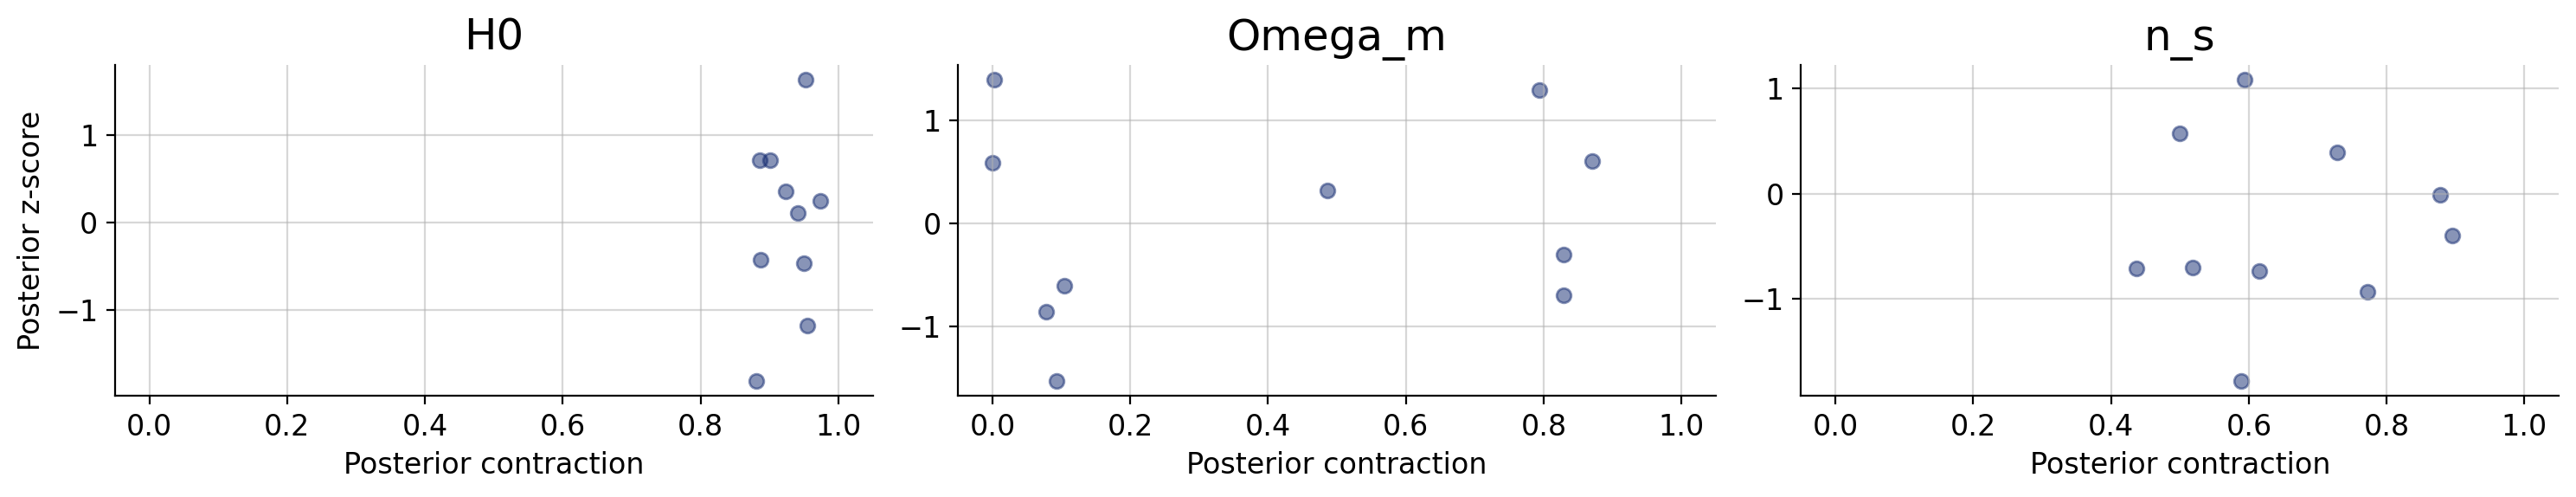

In [260]:
figures_affine = workflow_affine.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

# 2) Inference with Spline coupling

In [317]:
inference_network_spline = bf.networks.CouplingFlow(transform="spline")

In [319]:
workflow_spline = bf.BasicWorkflow(
     inference_network=inference_network_spline,
     summary_network=summary_network,
     adapter=adapter_std,
     simulator=simulator
)

In [320]:
history_spline = workflow_spline.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.
C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\bayesflow\adapters\transforms\standardize.py:74: FutureWarning: Dynamic standardization is deprecated and will be removed in later versions.Instead, use the standardize argument of the approximator / workflow instance or provide fixed mean and std arguments. You may incur some redundant computations if you keep this transform.
  warnings.warn(


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 125s 125s/step - loss: 4.2568 - val_loss: 4.3207
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step - loss: 4.1033 - val_loss: 3.8402
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step - loss: 3.8075 - val_loss: 4.0503
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step - loss: 3.7810 - val_loss: 4.4337
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step - loss: 3.8375 - val_loss: 4.6968
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step - loss: 3.9521 - val_loss: 4.2582
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step - loss: 3.8710 - val_loss: 4.5194
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step - loss: 4.0420 - val_loss: 4.3925
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step - loss: 3.6141 - val_loss: 3.7950
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step - loss: 3.3296 - val_loss: 3.5617
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step - loss: 3.5764 - val_loss: 3.7400
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step - loss: 3.

In [308]:
post_samples_spline = workflow_spline.sample(conditions=test_data, num_samples=1000)

In [335]:
# samples_spline["H0"][1]

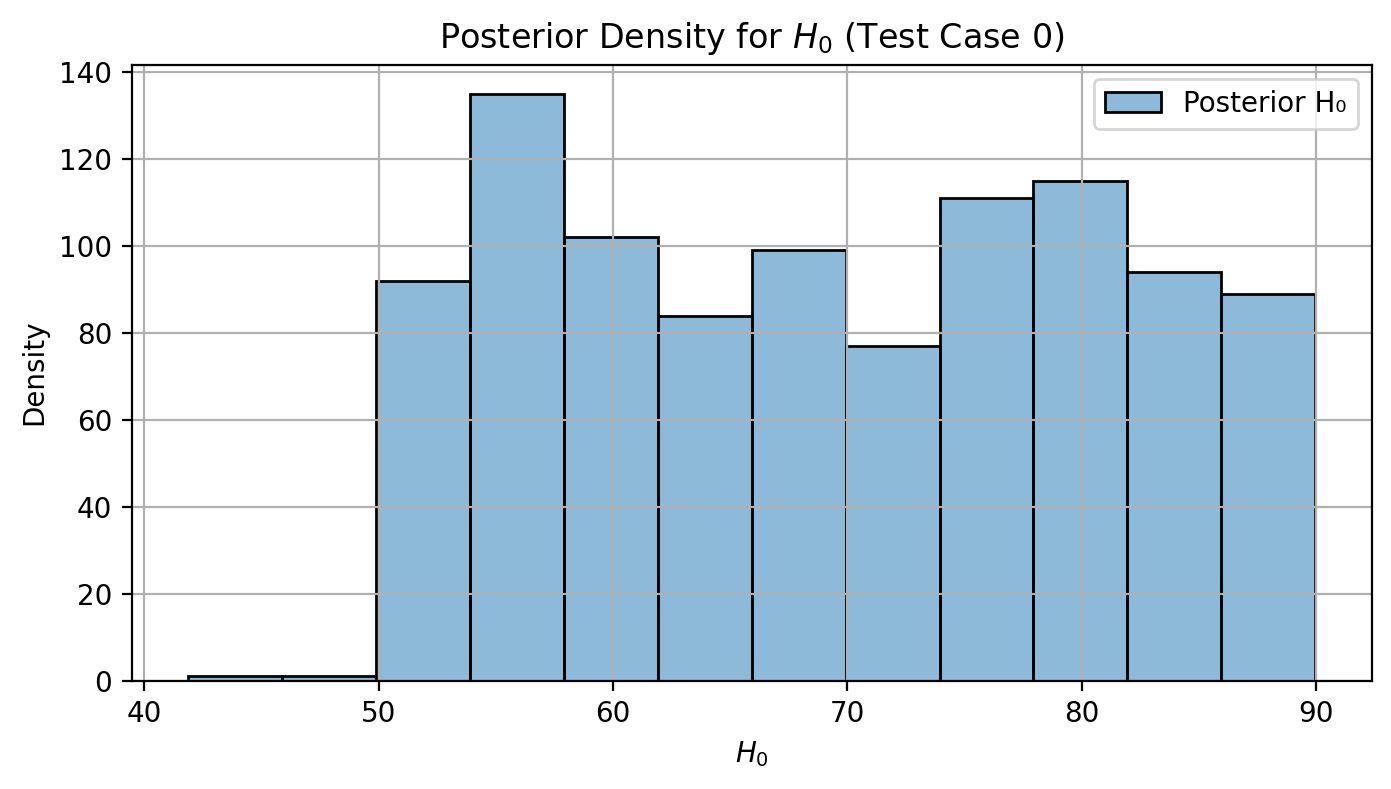

In [334]:
plt.figure(figsize=(8, 4))
sns.histplot(post_samples_spline["H0"][-1], fill=True, color="skyblue", label="Posterior H₀")
#sns.kdeplot(samples_spline["Omega_m"][1], fill=True, color="skyblue", label="Posterior H₀")
#sns.kdeplot(samples_spline["n_s"][1], fill=True, color="skyblue", label="Posterior H₀")
plt.title("Posterior Density for $H_0$ (Test Case 0)")
plt.xlabel("$H_0$")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()


In [311]:
#str(test_data)

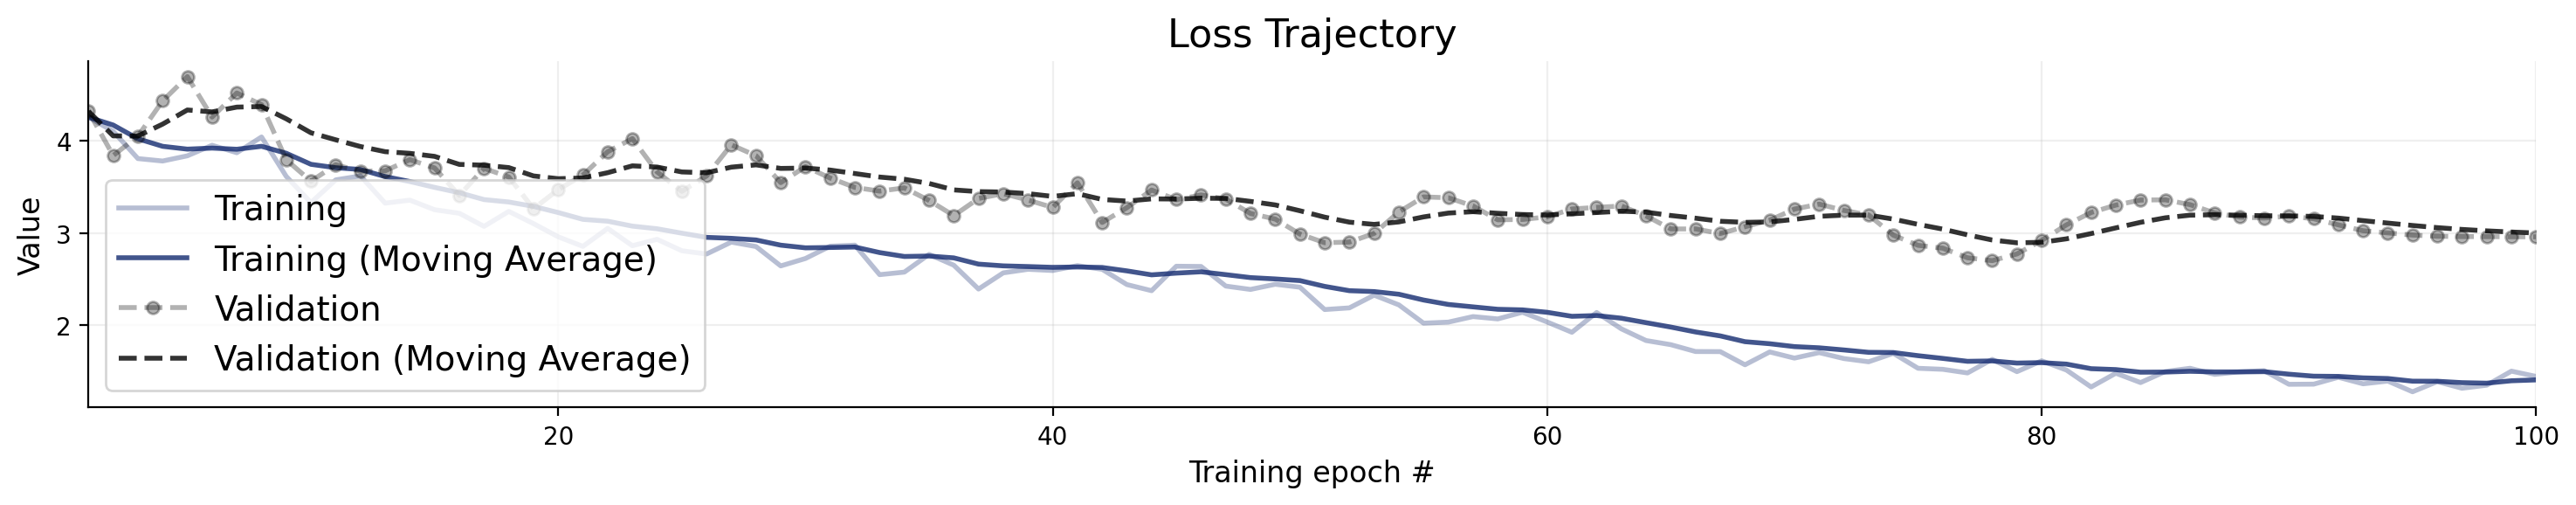

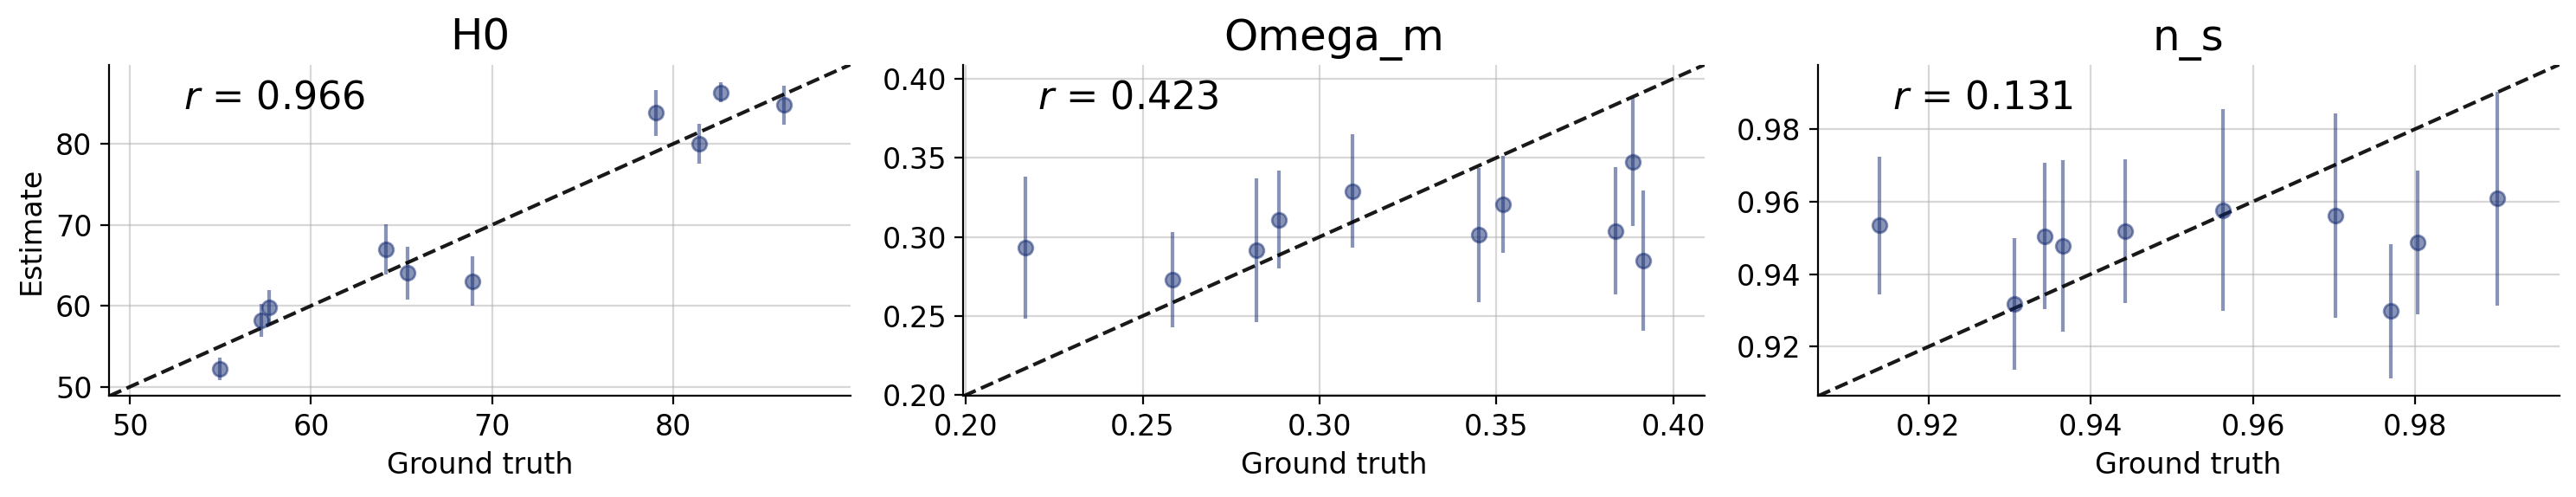

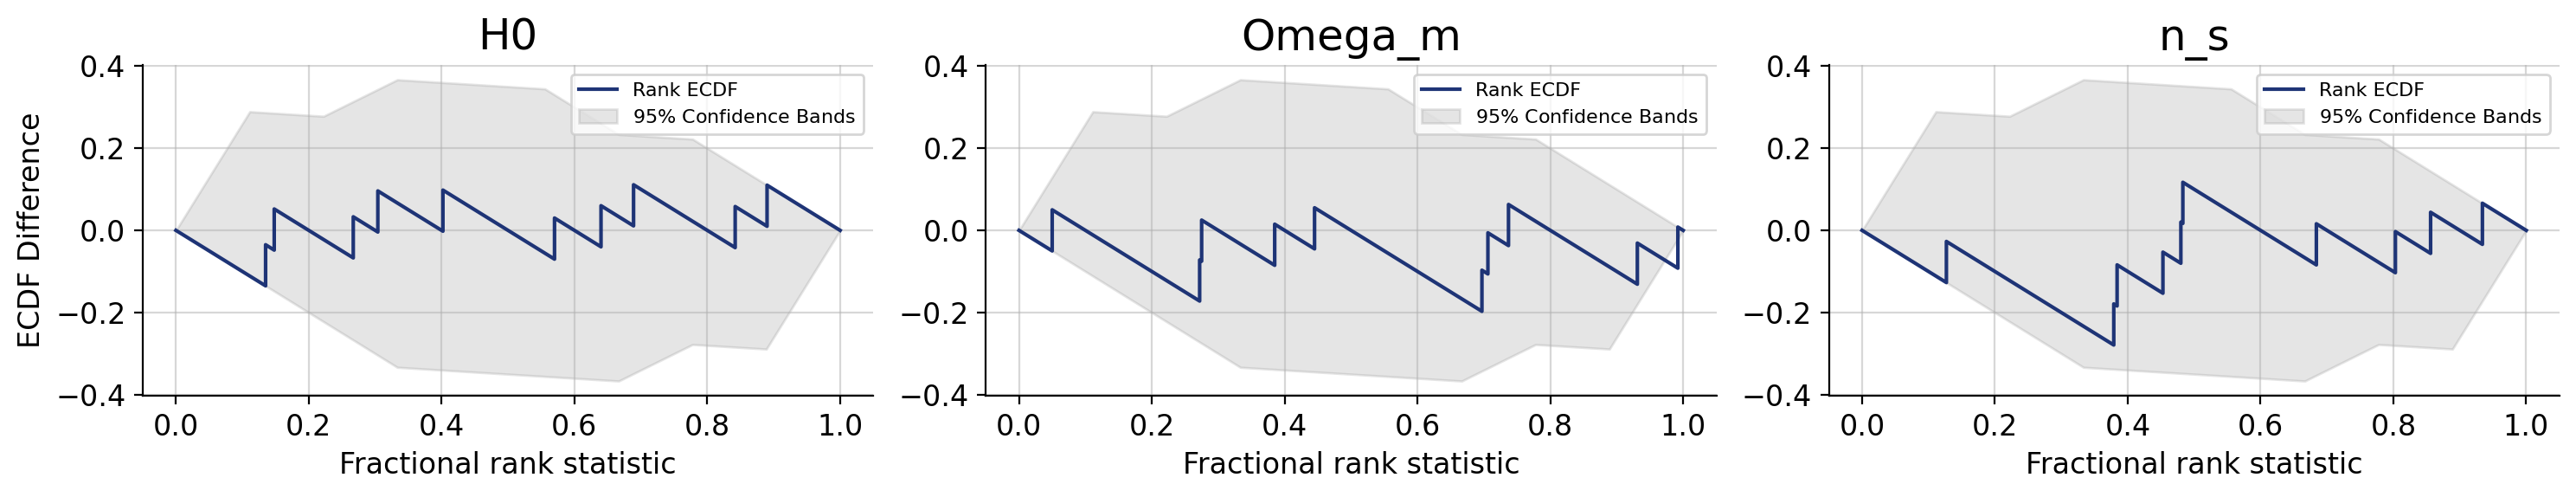

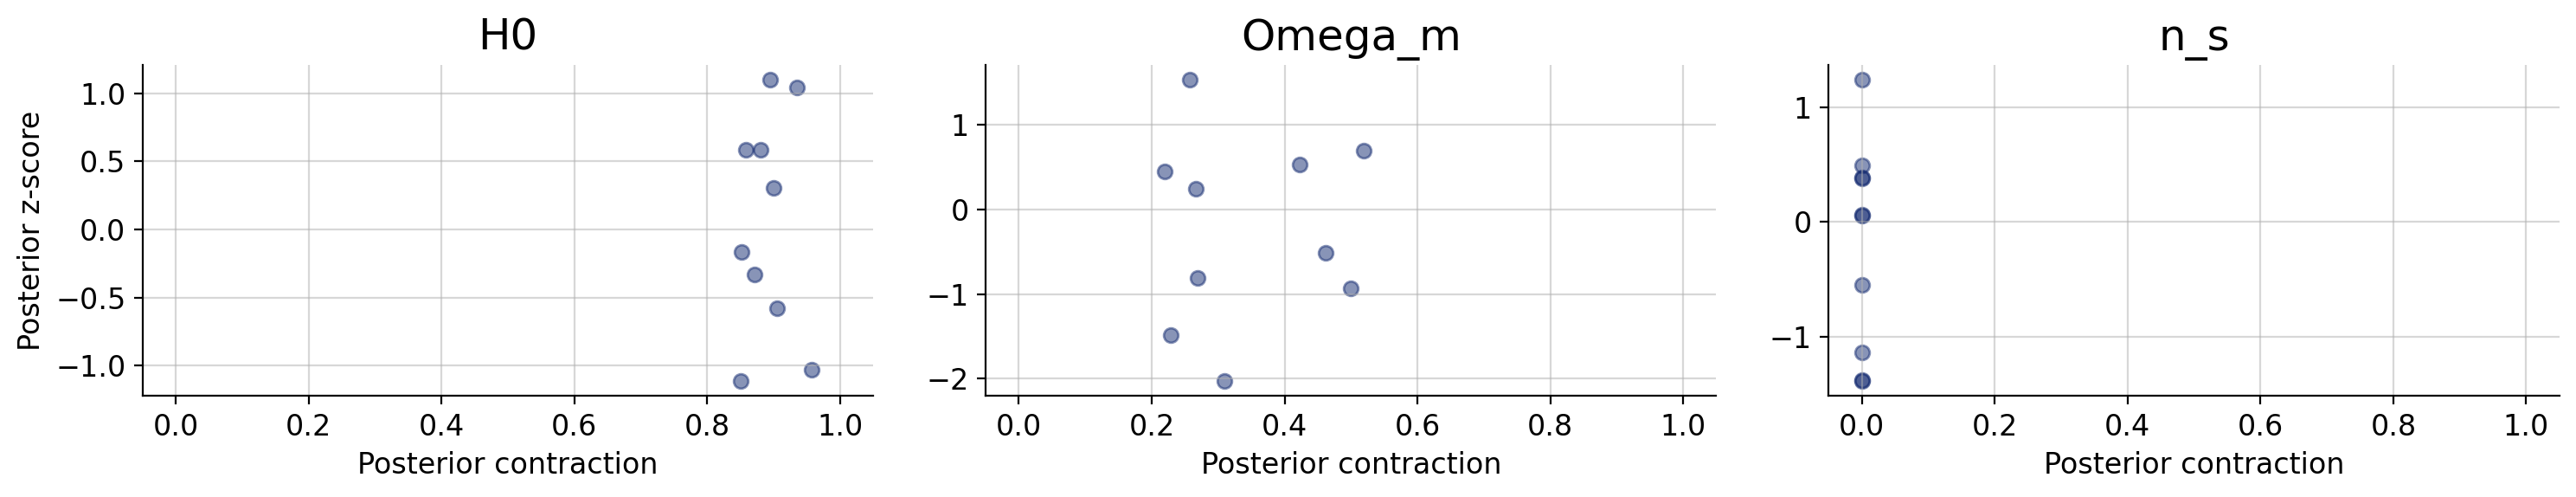

In [321]:
figures_spline = workflow_spline.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

# 3) Flow matching 

In [322]:
inference_network_flow = bf.networks.FlowMatching()

In [324]:
workflow_flow = bf.BasicWorkflow(
     inference_network=inference_network_flow,
     summary_network=summary_network,
     adapter=adapter_std,
     simulator=simulator
)

In [325]:
history_flow = workflow_flow.fit_offline(
    data = training_data,
    epochs=100,
    num_batches_per_epoch=200,
    batch_size=128,
    validation_data = validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - loss: 888.3741 - val_loss: 579.7760
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step - loss: 730.0281 - val_loss: 261.7020
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step - loss: 315.6625 - val_loss: 63.8019
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step - loss: 140.1149 - val_loss: 70.7160
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - loss: 143.8771 - val_loss: 39.7199
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step - loss: 100.0182 - val_loss: 34.9273
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - loss: 87.5133 - val_loss: 37.0321
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - loss: 59.6298 - val_loss: 19.4267
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step - loss: 47.7826 - val_loss: 15.0463
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - loss: 32.6641 - val_loss: 4.9018
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step - loss: 18.4812 - val_loss: 5.8323
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━

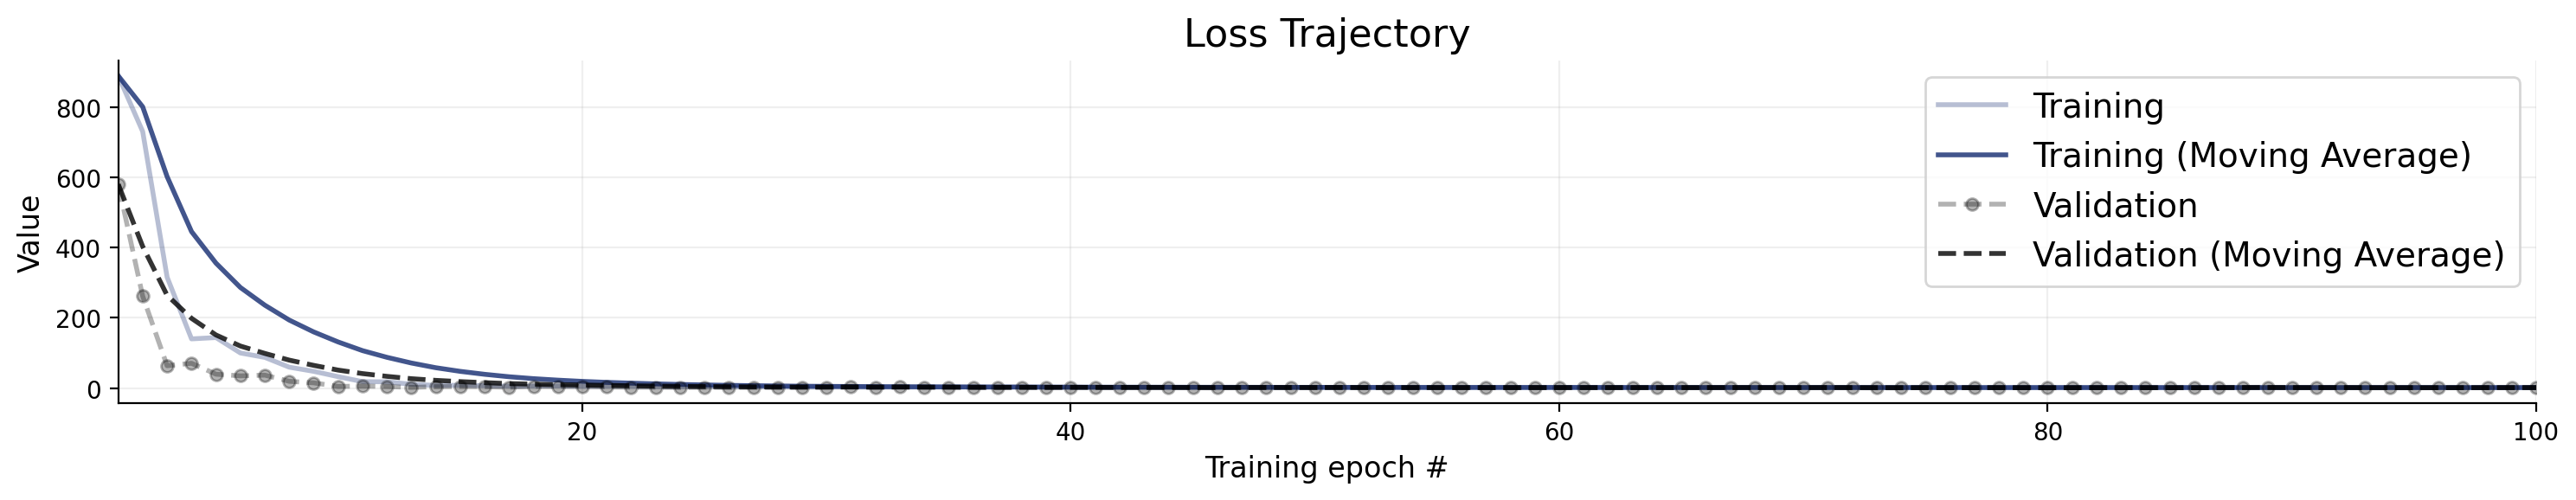

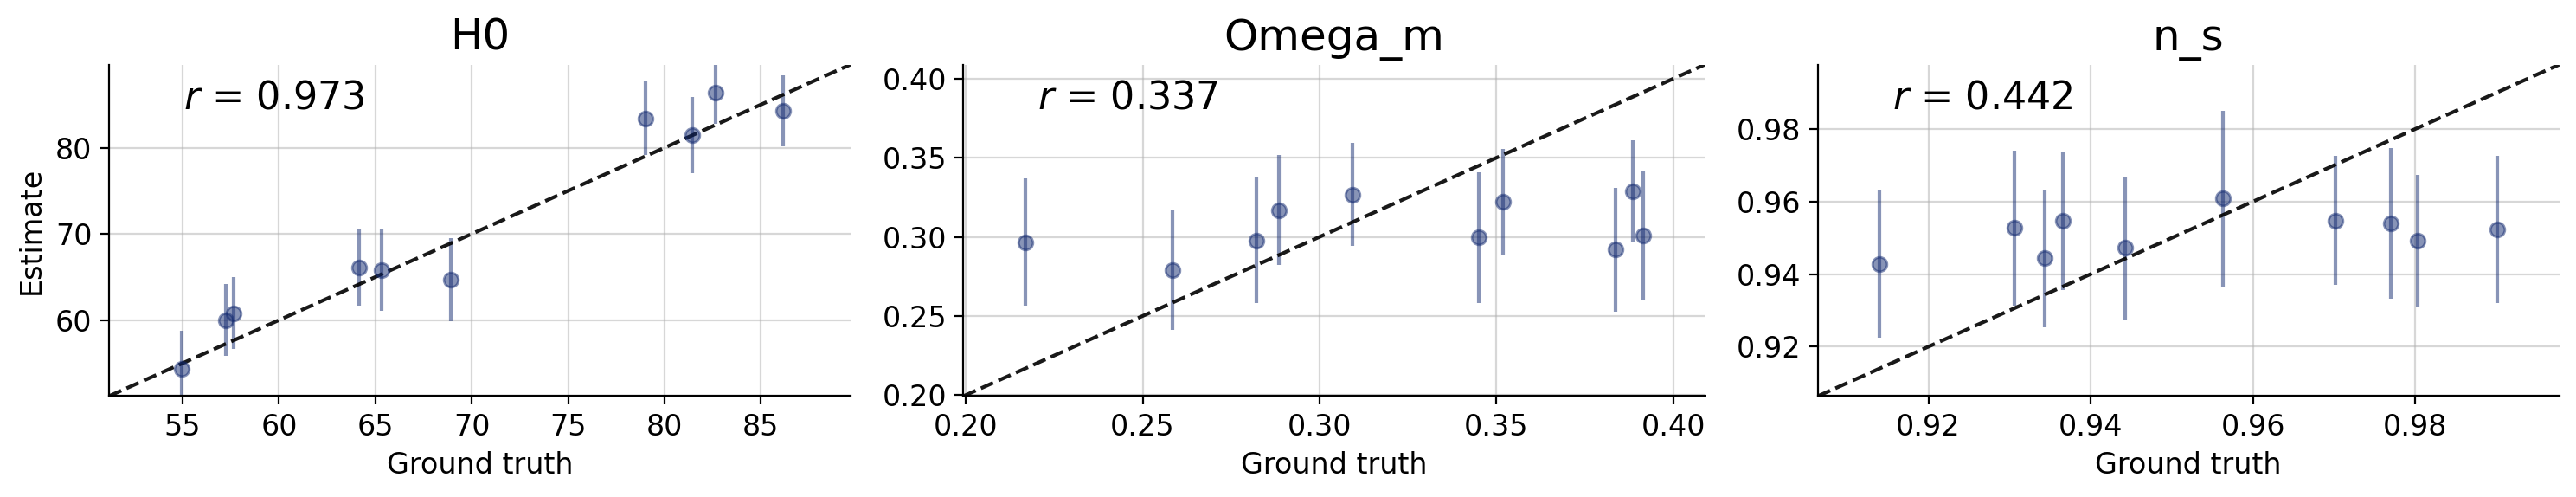

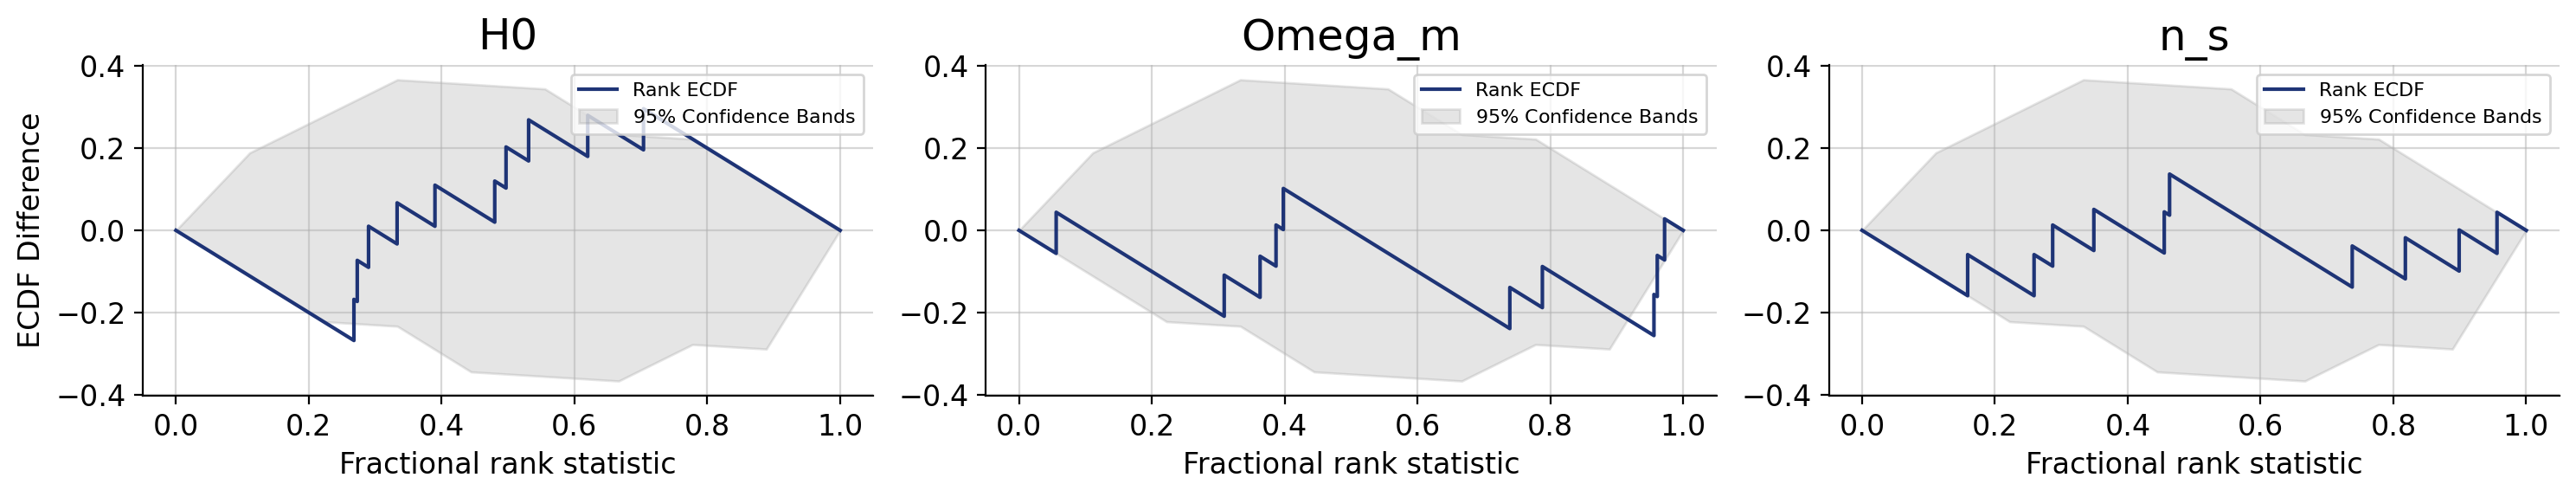

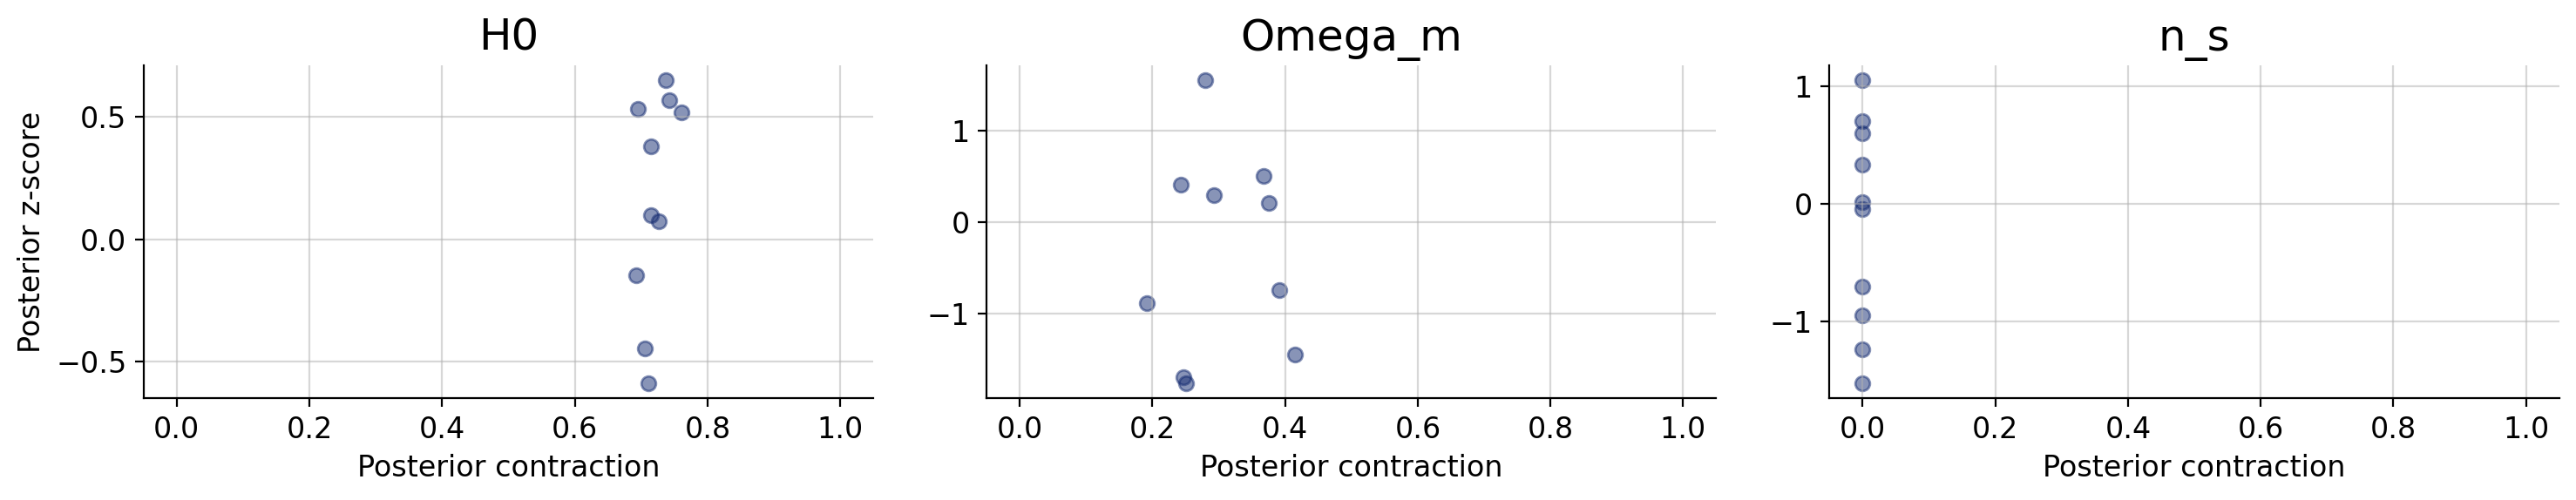

In [326]:
figures_spline = workflow_flow.plot_default_diagnostics(
    test_data=test_data,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)